In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import os
from tqdm import tqdm
import random
from pathlib import Path

# Machine Learning tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

#  Deep Learning tools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping

# Utilities
import gc

In [4]:
# Load training labels
train = pd.read_csv('/kaggle/input/spr-x-ray-age/train_age.csv')

# Convert imageId to filename (e.g., 000123.png)
train['imageId'] = train['imageId'].apply(lambda x: str(x).zfill(6) + ".png")

# View sample
train.head()

,imageId,age
0,000000.png,89.0
1,000001.png,72.0
2,000002.png,25.0
3,000003.png,68.0
4,000004.png,37.0


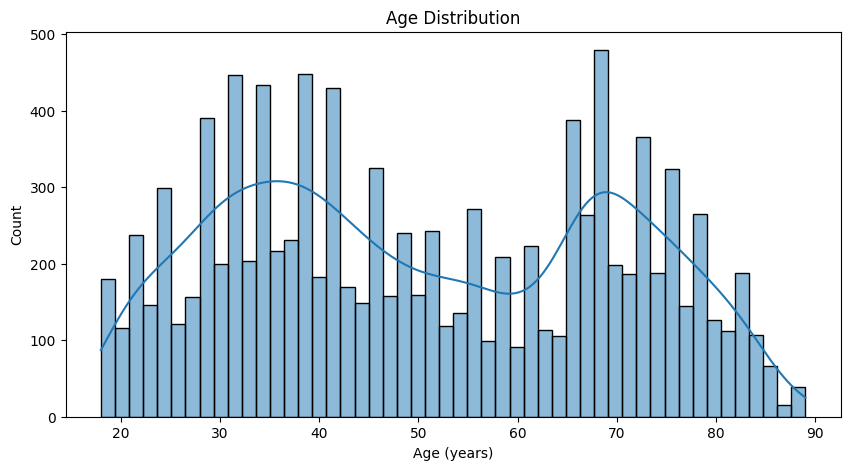

In [6]:
plt.figure(figsize=(10,5))
sns.histplot(train['age'], bins=50, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.show()

In [5]:
# Image size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Image augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Training generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory='/kaggle/input/spr-x-ray-age/kaggle/kaggle/train',
    x_col='imageId',
    y_col='age',
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='raw',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory='/kaggle/input/spr-x-ray-age/kaggle/kaggle/train',
    x_col='imageId',
    y_col='age',
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='raw',
    subset='validation',
    shuffle=False
)

Found 8562 validated image filenames.
Found 2140 validated image filenames.


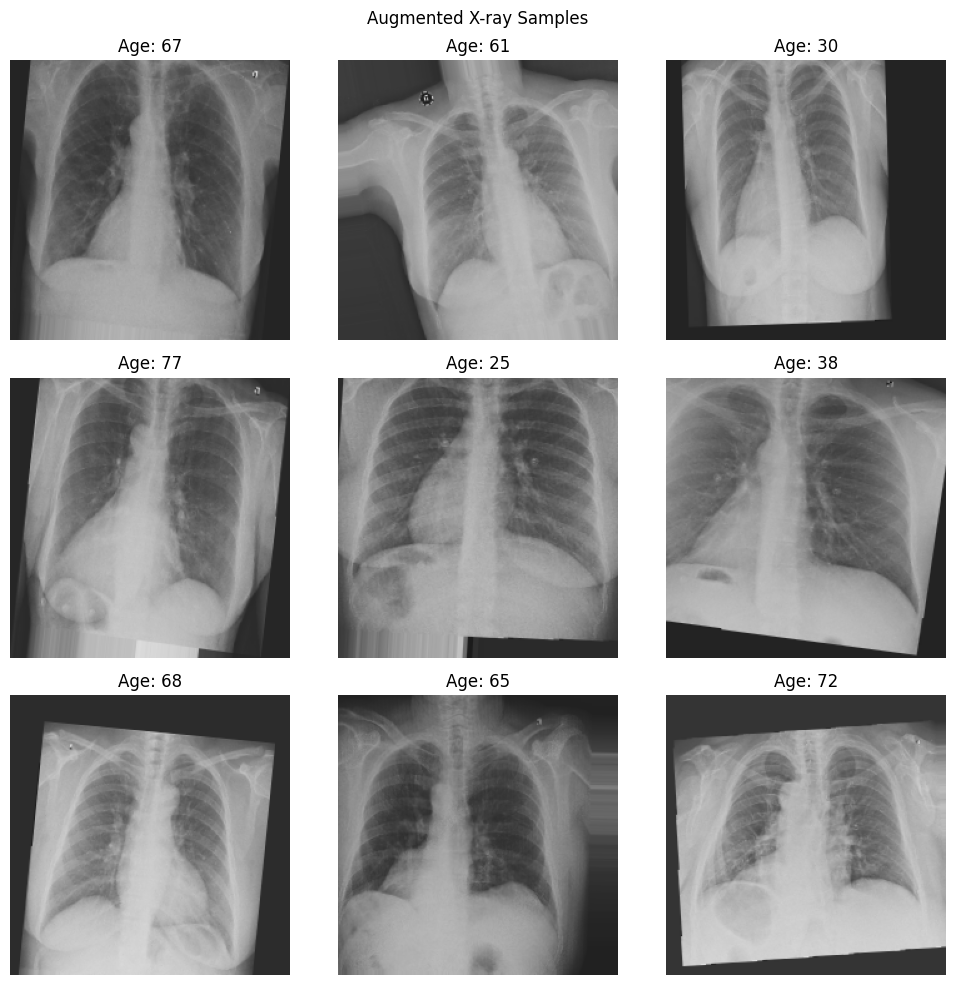

In [7]:
# Get batch of augmented images
augmented_imgs, labels = next(train_generator)

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_imgs[i])
    plt.title(f"Age: {int(labels[i])}")
    plt.axis('off')
plt.suptitle("Augmented X-ray Samples")
plt.tight_layout()
plt.show()

In [9]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

# Freeze first 300 layers
for layer in base_model.layers[:300]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='mae',
    metrics=['mae']
)

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,332,929 (27.97 MB)

 Trainable params: 3,184,833 (12.15 MB)

 Non-trainable params: 4,148,096 (15.82 MB)

In [11]:
early_stop = EarlyStopping(
    monitor='val_mae',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20


I0000 00:00:1751912852.117991     107 service.cc:148] XLA service 0x7847680056a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751912852.118821     107 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751912856.684685     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/268 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - loss: 47.9390 - mae: 47.9390   

I0000 00:00:1751912883.318630     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


268/268 ━━━━━━━━━━━━━━━━━━━━ 628s 2s/step - loss: 48.6692 - mae: 48.6692 - val_loss: 39.6707 - val_mae: 39.6707
Epoch 2/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step - loss: 32.2896 - mae: 32.2896 - val_loss: 13.7177 - val_mae: 13.7177
Epoch 3/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - loss: 12.9525 - mae: 12.9525 - val_loss: 9.0132 - val_mae: 9.0132
Epoch 4/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - loss: 9.7147 - mae: 9.7147 - val_loss: 8.5832 - val_mae: 8.5832
Epoch 5/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - loss: 9.4644 - mae: 9.4644 - val_loss: 8.2417 - val_mae: 8.2417
Epoch 6/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - loss: 9.1556 - mae: 9.1556 - val_loss: 8.2127 - val_mae: 8.2127
Epoch 7/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - loss: 9.0220 - mae: 9.0220 - val_loss: 8.0639 - val_mae: 8.0639
Epoch 8/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - loss: 9.0234 - mae: 9.0234 - val_loss: 7.9397 - val_mae: 7.9397
Epoch 9/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 370s 1s/s

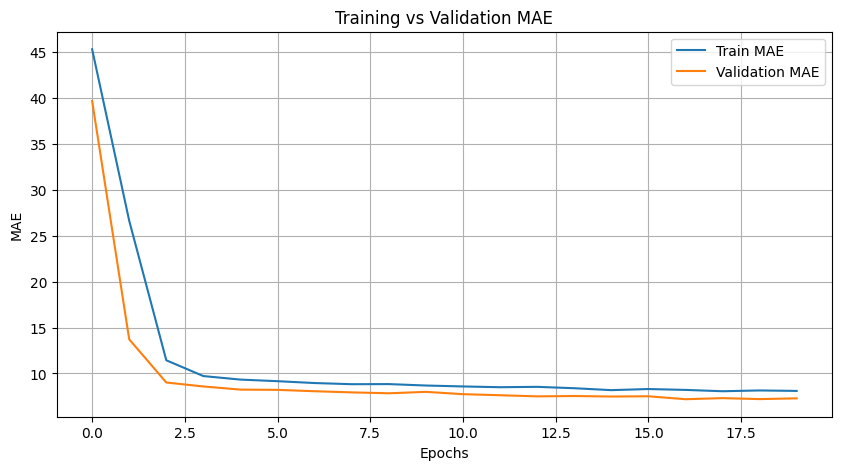

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()
plt.show()

67/67 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step


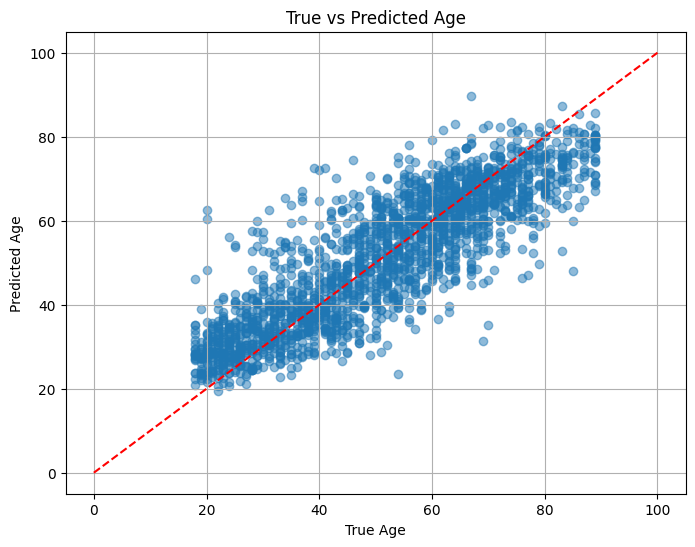

In [13]:
# Get true and predicted values
y_true = val_generator.labels
y_pred = model.predict(val_generator)

# Scatter Plot: True vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
plt.title("True vs Predicted Age")
plt.grid(True)
plt.plot([0, 100], [0, 100], 'r--')  # Perfect prediction line
plt.show()

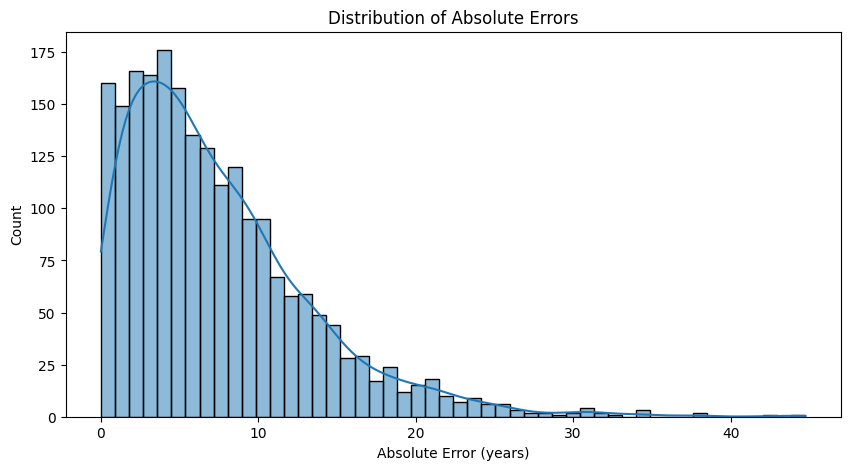

In [16]:
import seaborn as sns

errors = np.abs(y_true - y_pred)
plt.figure(figsize=(10,5))
sns.histplot(errors, bins=50, kde=True)
plt.title("Distribution of Absolute Errors")
plt.xlabel("Absolute Error (years)")
plt.ylabel("Count")
plt.show()

In [14]:
# Predict on validation set
val_preds = model.predict(val_generator)

# Get true values
y_true = val_generator.labels
y_pred = val_preds.flatten()

errors = np.abs(y_true - y_pred)


67/67 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step


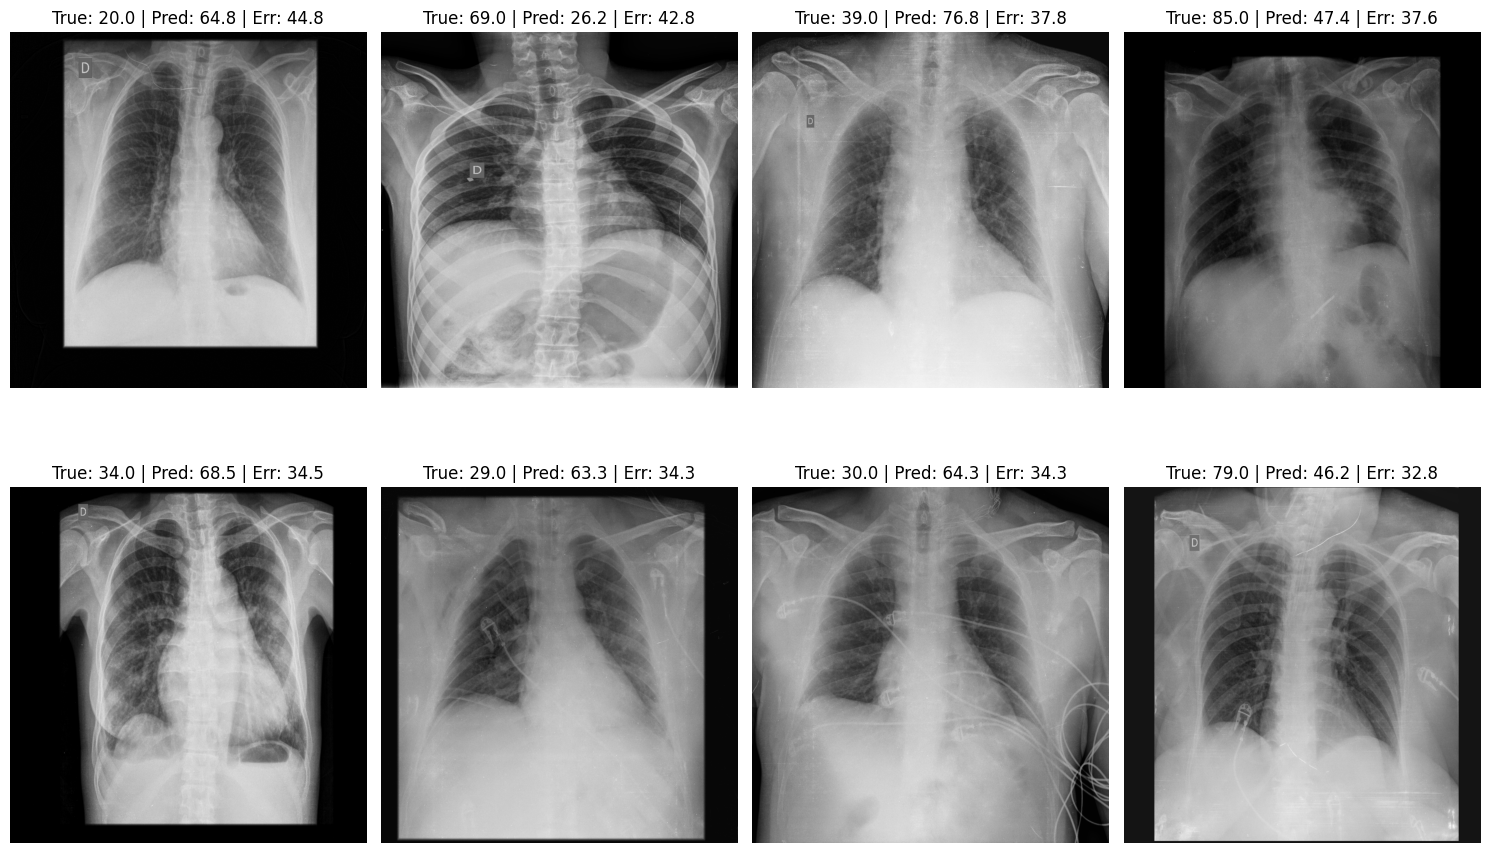

In [15]:
n = 8

# ordering photes according to error
worst_idx = errors.argsort()[::-1][:n]


file_paths = val_generator.filepaths


plt.figure(figsize=(15, 10))
for i, idx in enumerate(worst_idx):
    img = plt.imread(file_paths[idx])
    plt.subplot(2, 4, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {y_true[idx]:.1f} | Pred: {y_pred[idx]:.1f} | Err: {errors[idx]:.1f}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [20]:
# Load test data
sample_submission = pd.read_csv('/kaggle/input/spr-x-ray-age/sample_submission_age.csv')

# Build file path
def get_test_file_path(image_id):
    return f"/kaggle/input/spr-x-ray-age/kaggle/kaggle/test/{str(image_id).zfill(6)}.png"

sample_submission['file_path'] = sample_submission['imageId'].apply(get_test_file_path)

In [22]:
# Define pixels size if not defined earlier
pixels = 224

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    x_col='file_path',
    y_col=None,
    target_size=(pixels, pixels),
    color_mode='rgb',
    class_mode=None,
    shuffle=False,
    batch_size=32
)

Found 11747 validated image filenames.


In [23]:
preds = model.predict(test_generator, verbose=1)

368/368 ━━━━━━━━━━━━━━━━━━━━ 467s 1s/step


In [24]:
sample_submission['age'] = preds.flatten()
sample_submission[['imageId', 'age']].to_csv('submission.csv', index=False)